## Sampling Uniformly over the space of junction trees. 

We want to show that $\pi(G) \propto 1/\pi(T)$. To show this carrying the following steps:

* For every decomposable graph $G \in \mathcal G$ compute the number of junction trees that generate $G$, that is $|G(T)| = \{T: g(T) = G\}$. 
* Generate an MCMC chain $\mathcal T$. Convert it over a chain over decomposable graphs, by the operator $g$
* Let $N(G)$ be the frequency of graph $G$ in the chain.

Then we show that 
$$ \frac{N(G)}{|G(T)|} \propto \frac{1}{|\mathcal G|}$$

Here $g(T)$ is the unique decomposbale graph generated by junction tree $T$.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import time
sys.path.append('..')
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns

import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.mh_parallel as pdg
import parallelDG.graph.junction_tree as jtlib
from networkx.drawing.nx_pydot import graphviz_layout
import itertools
import parallelDG.auxiliary_functions as auxlib

sns.set_style("whitegrid")
options = {
    "font_size": 12,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}

    
def dedup_traj(traj): 
    print('length traj {}'.format(len(traj)))
    new_lst = []
    for i in traj:
        if not new_lst or new_lst[-1] != i:
            new_lst.append(i)
    return new_lst
    

## Over reduced Junction trees

* How to generate uniform over G

* Set t.randomize_jt()

* set randomization at every step 

* set single-node update to 1e10 or t.order()

In [2]:
graph_size = 7

In [4]:
tic = time.time()
all_edges = auxlib.edges_powerset(graph_size)
all_graphs_of_size_p = list(auxlib.powerset(all_edges))
decomp_table = auxlib.filter_decomposable_graphs(all_graphs_of_size_p, graph_size)
print("#.all graph {}, #decomp graphs {} of {} nodes".format(len(all_graphs_of_size_p), 
                                                              len(decomp_table), 
                                                              graph_size))
toc = time.time()
print('time took {:.2f}sec'.format(toc - tic))

KeyboardInterrupt: 

In [3]:
#auxlib.save_decomposable_table(decomp_table, '7_vertex_decomposable_graphs.csv')
decomp_table = pd.read_csv('7_vertex_decomposable_graphs.csv')

In [7]:
traj = pdg.sample_trajectory_uniform(n_samples =1000000, 
                                     randomize = 1,
                                     graph_prior = ['uniform'],
                                     graph_size  = graph_size, 
                                     single_move= True,
                                     cache = None)

Metropolis-Hastings samples - single-move: 100%|██████████| 999999/999999 [12:52<00:00, 1294.41it/s]

Total of 1000000 updates, for an average of 1.00 per iteration or 1294.32updates/sec
Acceptance rate 0.9616


In [8]:
traj.set_graph_trajectories(index_type = 'mcmc_subindex')
#traj.trajectory = dedup_traj(traj.trajectory)
print('length traj {}'.format(len(traj.trajectory)))
graph_table = auxlib.count_decomposable_graphs_trajectories(traj.trajectory)

mcmc_subindex
length traj 1000000


In [9]:
df = auxlib.join_with_decom_table(graph_table, decomp_table)

In [7]:
#df = df.drop(df['count'].idxmax())

In [10]:
df['count_jt'] = df['count'].fillna(0).values/df['n_jt'].values
df['L'] = np.clip(graph_size - df['n_clqs'], 1.0, None)
df['count_t'] = df['count'].fillna(0).values/(df['L'].values ** (df['L'].values - 3.0))

In [11]:
df['count'].isna().sum()

515221

In [12]:
df['count'].isna().sum()/float(df.shape[0])

0.8341295988990974

In [13]:
df['count_jt_clip'] = df['count_jt'].values
np.random.shuffle(df['count_jt_clip'].values)


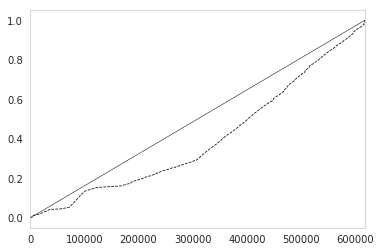

In [14]:
auxlib.pdf_plot(df['count_jt'])

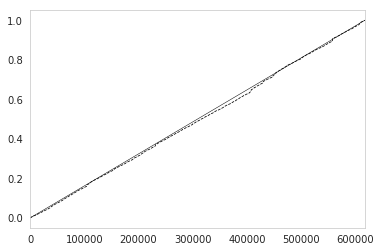

In [15]:
auxlib.pdf_plot(df['count_jt_clip'])

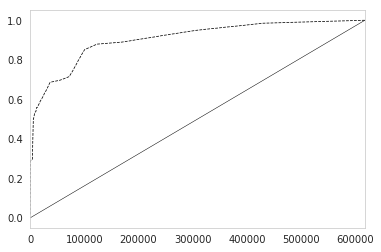

In [16]:
auxlib.pdf_plot(df['count_t'])

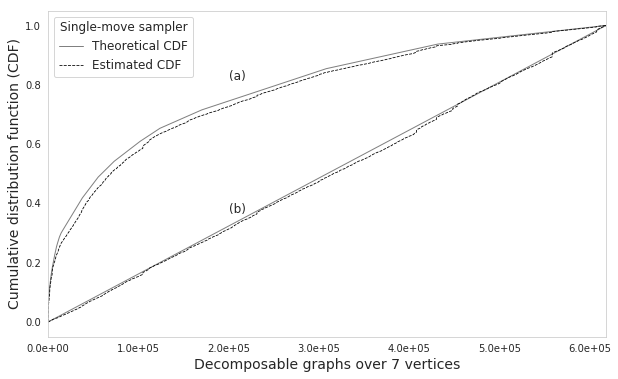

In [18]:
 "plotting the probability density function"
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))
x = df['n_jt'].values
a = float(np.sum(x))
b = np.cumsum(x)
ax = pd.Series(b/a).plot(color='grey', linestyle='solid', linewidth = 1, label='Theoretical CDF')
N = len(x)
plt.plot([0, N], [0, 1], color='grey', linewidth=1)
y = df['count_jt_clip'].fillna(0).values
y = y * df['n_jt'].values
a = float(np.sum(y))
b = np.cumsum(y)
ax = pd.Series(b/a).plot(color='black', linestyle='dashed', linewidth = 0.8, label='Estimated CDF')
y = df['count_jt_clip'].fillna(0).values
a = float(np.sum(y))
b = np.cumsum(y)
ax = pd.Series(b/a).plot(color='black', linestyle='dashed', linewidth = 0.8, label = '')
plt.grid(False)
# Change the x-axis to scientific notation
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1e}'.format(x)))
plt.xlabel('Decomposable graphs over 7 vertices',fontsize=14)
plt.ylabel('Cumulative distribution function (CDF)', fontsize=14)
plt.text(200000, 0.85, '(a)', fontsize=12, va='top')
plt.text(200000, 0.4, '(b)', fontsize=12, va='top')

legend = plt.legend(title='Single-move sampler',  fontsize='large')
plt.setp(legend.get_title(), fontsize='large')


# Save the figure as a PDF file
plt.savefig('reduced_jt_CDF.pdf', format='pdf')
plt.show()

# Over junction trees

In [4]:
traj = pdg.sample_trajectory_uniform(n_samples =1000000, 
                                     randomize = 100,
                                     graph_prior = ['uniform'],
                                     graph_size  = graph_size, 
                                     single_move= True,
                                     cache = None)

Metropolis-Hastings samples - single-move: 100%|██████████| 999999/999999 [01:31<00:00, 10923.76it/s]

Total of 1000000 updates, for an average of 1.00 per iteration or 10917.25updates/sec
Acceptance rate 0.7125


In [5]:
traj.set_graph_trajectories(index_type = 'mcmc_subindex')
#traj.trajectory = dedup_traj(traj.trajectory)
print('length traj {}'.format(len(traj.trajectory)))
graph_table = auxlib.count_decomposable_graphs_trajectories(traj.trajectory)

mcmc_subindex
length traj 1000000


In [6]:
df = auxlib.join_with_decom_table(graph_table, decomp_table)

In [7]:
df['count_jt'] = df['count'].fillna(0).values/df['n_jt'].values
df['L'] = np.clip(graph_size - df['n_clqs'], 1.0, None)
df['count_t'] = df['count'].fillna(0).values/(df['L'].values ** (df['L'].values - 3.0))

In [8]:
df['count'].isna().sum()/float(df.shape[0])

0.9610134779617112

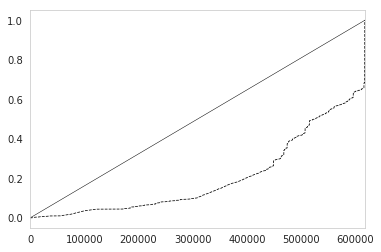

In [9]:
auxlib.pdf_plot(df['count'].fillna(0))

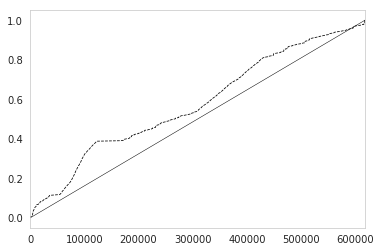

In [10]:
auxlib.pdf_plot(df['count_t'])

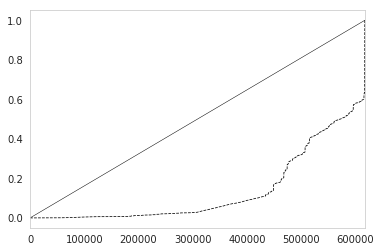

In [11]:
auxlib.pdf_plot(df['count_jt'])

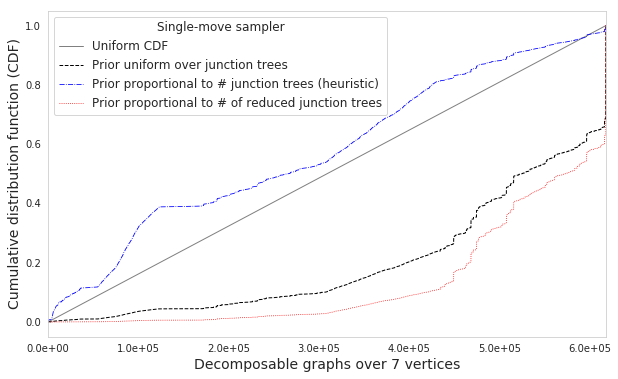

In [19]:
 "plotting the probability density function"
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))
x = df['count'].fillna(0).values
a = float(np.sum(x))
b = np.cumsum(x)
N = len(x)
plt.plot([0, N], [0, 1], color='grey', linewidth=1, label='Uniform CDF')
ax = pd.Series(b/a).plot(color='black', linestyle='dashed', linewidth = 1, label='Prior uniform over junction trees')

y = df['count_t'].fillna(0).values
a = float(np.sum(y))
b = np.cumsum(y)
ax = pd.Series(b/a).plot(color='blue', linestyle='dashdot', linewidth = 0.8, label = 'Prior proportional to # junction trees (heuristic)')
y = df['count_jt'].fillna(0).values
a = float(np.sum(y))
b = np.cumsum(y)
ax = pd.Series(b/a).plot(color='red', linestyle='dotted', linewidth = 0.8, label = 'Prior proportional to # of reduced junction trees')
plt.grid(False)
# Change the x-axis to scientific notation
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1e}'.format(x)))
plt.xlabel('Decomposable graphs over 7 vertices',fontsize=14)
plt.ylabel('Cumulative distribution function (CDF)', fontsize=14)
#plt.text(200000, 0.85, '(a)', fontsize=12, va='top')
#plt.text(200000, 0.4, '(b)', fontsize=12, va='top')

legend = plt.legend(title='Single-move sampler',  fontsize='large')
plt.setp(legend.get_title(), fontsize='large')


# Save the figure as a PDF file
plt.savefig('junction_tree_CDF_single_move.pdf', format='pdf')
plt.show()

## Parallel sampler

In [4]:
traj = pdg.sample_trajectory_uniform(n_samples =1000000, 
                                     randomize = 100,
                                     graph_prior = ['uniform'],
                                     graph_size  = graph_size, 
                                     single_move= False,
                                     cache = None)

Metropolis-Hastings samples - parallel moves: 100%|██████████| 999999/999999 [01:20<00:00, 12365.38it/s]

Total of 2632593 updates, for an average of 2.63 per iteration or 32521.30updates/sec
Acceptance rate 0.6670


In [5]:
traj.set_graph_trajectories(index_type='mcmc_subindex')
#traj.trajectory = dedup_traj(traj.trajectory)
print('length traj {}'.format(len(traj.trajectory)))
graph_table = auxlib.count_decomposable_graphs_trajectories(traj.trajectory)

mcmc_subindex
length traj 2632593


In [6]:
df = auxlib.join_with_decom_table(graph_table, decomp_table)

In [7]:
df['count_jt'] = df['count'].fillna(0).values/df['n_jt'].values
df['L'] = np.clip(graph_size - df['n_clqs'], 1.0, None)
df['count_t'] = df['count'].fillna(0).values/(df['L'].values ** (df['L'] - 2.0))

In [8]:
df['count'].isna().sum()/float(df.shape[0])

0.9767515279070709

[None, None]

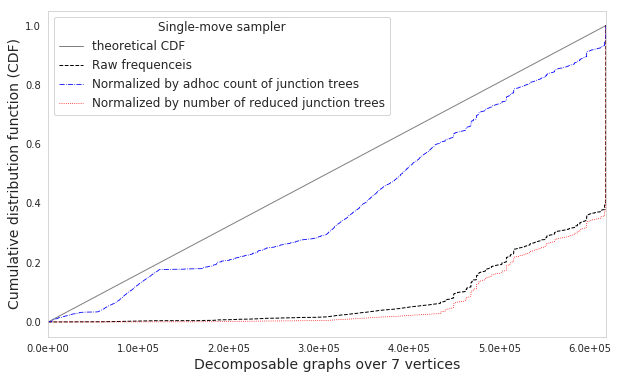

In [9]:
 "plotting the probability density function"
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))
x = df['count'].fillna(0).values
a = float(np.sum(x))
b = np.cumsum(x)
N = len(x)
plt.plot([0, N], [0, 1], color='grey', linewidth=1, label='theoretical CDF')
ax = pd.Series(b/a).plot(color='black', linestyle='dashed', linewidth = 1, label='Raw frequenceis')

y = df['count_t'].fillna(0).values
a = float(np.sum(y))
b = np.cumsum(y)
ax = pd.Series(b/a).plot(color='blue', linestyle='dashdot', linewidth = 0.8, label = 'Normalized by adhoc count of junction trees')
y = df['count_jt'].fillna(0).values
a = float(np.sum(y))
b = np.cumsum(y)
ax = pd.Series(b/a).plot(color='red', linestyle='dotted', linewidth = 0.8, label = 'Normalized by number of reduced junction trees')
plt.grid(False)
# Change the x-axis to scientific notation
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1e}'.format(x)))
plt.xlabel('Decomposable graphs over 7 vertices',fontsize=14)
plt.ylabel('Cumulative distribution function (CDF)', fontsize=14)
#plt.text(200000, 0.85, '(a)', fontsize=12, va='top')
#plt.text(200000, 0.4, '(b)', fontsize=12, va='top')

legend = plt.legend(title='Parallel sampler',  fontsize='large')
plt.setp(legend.get_title(), fontsize='large')


# Save the figure as a PDF file
#plt.savefig('junction_tree_CDF_single_move.pdf', format='pdf')

In [10]:
traj.set_graph_trajectories()
#traj.trajectory = dedup_traj(traj.trajectory)
print('length traj {}'.format(len(traj.trajectory)))
graph_table = auxlib.count_decomposable_graphs_trajectories(traj.trajectory)

mcmc_index
length traj 1000000


In [11]:
df['count'] = 0
df = auxlib.join_with_decom_table(graph_table, decomp_table)

In [12]:
df['count_jt'] = df['count'].fillna(0).values/df['n_jt'].values
df['L'] = np.clip(graph_size - df['n_clqs'], 1.0, None)
df['count_t'] = df['count'].fillna(0).values/(df['L'].values ** (df['L'] - 2.0))

[None, None]

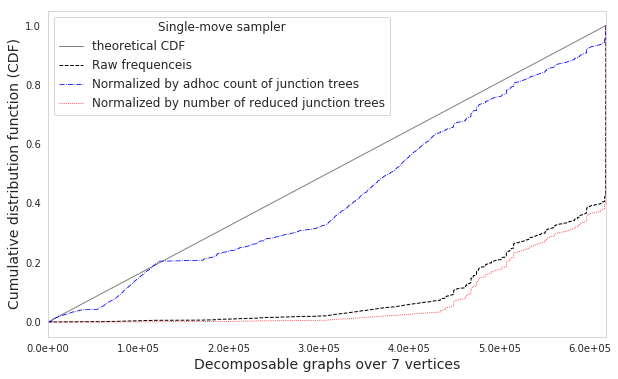

In [13]:
 "plotting the probability density function"
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))
x = df['count'].fillna(0).values
a = float(np.sum(x))
b = np.cumsum(x)
N = len(x)
plt.plot([0, N], [0, 1], color='grey', linewidth=1, label='theoretical CDF')
ax = pd.Series(b/a).plot(color='black', linestyle='dashed', linewidth = 1, label='Raw frequenceis')

y = df['count_t'].fillna(0).values
a = float(np.sum(y))
b = np.cumsum(y)
ax = pd.Series(b/a).plot(color='blue', linestyle='dashdot', linewidth = 0.8, label = 'Normalized by adhoc count of junction trees')
y = df['count_jt'].fillna(0).values
a = float(np.sum(y))
b = np.cumsum(y)
ax = pd.Series(b/a).plot(color='red', linestyle='dotted', linewidth = 0.8, label = 'Normalized by number of reduced junction trees')
plt.grid(False)
# Change the x-axis to scientific notation
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1e}'.format(x)))
plt.xlabel('Decomposable graphs over 7 vertices',fontsize=14)
plt.ylabel('Cumulative distribution function (CDF)', fontsize=14)
#plt.text(200000, 0.85, '(a)', fontsize=12, va='top')
#plt.text(200000, 0.4, '(b)', fontsize=12, va='top')

legend = plt.legend(title='Parallel sampler',  fontsize='large')
plt.setp(legend.get_title(), fontsize='large')